In [21]:
%matplotlib inline
import local_broom

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import time
from qcodes import Station, Instrument
from scipy.signal import find_peaks
from tqdm import tqdm

from monty import Monty
from liveplot import LivePlot, LiveContourPlot
import feedback
import swiper
import MDAC
from fridge import Fridge

# Import the neighbouring files. In may/
import may.dots as dots
from may.custom_devices import connect_to_gb, newSiDot

In [14]:
#%% Connect to instruments

# close any open instruments 
try:
    mdac = Instrument.find_instrument("mdac")
    mdac.close()
except KeyError:
    print('Attempting to remove instrument with name mdac. Does not exist')
    
try:
    lockin = Instrument.find_instrument("sr860_top")
    lockin.close()
except KeyError:
    print("Cannot remove instrument with name sr860_top. Does not exist")

scfg = Station(config_file='/Users/LD2007/Documents/Si_CMOS_james/measurements/system.yaml')

mdac = MDAC.MDAC('mdac', 'ASRL11::INSTR')
lockin = scfg.load_instrument('sr860_top')

# Create our custom MDAC mappings
gb_control_si = connect_to_gb(mdac)
si = newSiDot(mdac)
fridge = Fridge("BlueFors_LD")

Cannot remove instrument with name sr860_top. Does not exist
Connected to: QNL Sydney MDAC (serial:0x32353532353551040030003E, firmware:1.8) in 4.30s
Connected to: Stanford_Research_Systems SR860 (serial:004279, firmware:V1.51) in 0.12s
Loading GB driver and connecting
Manually Open Breakout_box_top_ch15_LCB
Manually Open Breakout_box_bot_ch09_RCB
Manually Open Breakout_box_bot_ch17_RG
Manually Open Breakout_box_top_ch17_ResB
Manually Open Breakout_box_top_ch19_P3
Manually Open Breakout_box_top_ch13_P2
Manually Open Breakout_box_top_ch04_P1
Manually Open Breakout_box_top_ch02_SETB
Manually Open Breakout_box_bot_ch04_SRB
Manually Open Breakout_box_bot_ch06_SLB
Manually Open Breakout_box_top_ch10_ST
Manually Open Breakout_box_top_ch25_bias
Using base URL https://qphys1114.research.ext.sydney.edu.au/therm_flask/BlueFors_LD


In [15]:
experiment = {
    "desc": "Test the RF code for sweeping the SET."
}

monty = Monty("rf.set testing", experiment)

Started new experiment rf.set_testing


In [16]:
si.ST()

3.234749

In [17]:
# Get our surroundings

low = 3.2
high = 3.45
pts = 500

parameters = {
    "desc": "Quick 1D scan of the SET over ST",
    "ST":   f"range from {low}v -> {high}v, over {pts} pts",
    "SLB":  f"Fixed at {si.SLB()}V",
    "SRB":  f"Fixed at {si.SRB()}V",
    }

monty.newrun("1D SET sweep", parameters)
result = swiper.sweep1d(lockin,
               si.ST, low, high, pts, 
               delay_time=0.3, monty=monty)  # overlap points so we average


monty.save(result)

Started new run 1D_SET_sweep
Sweeping Si28_quantum_dot_ST from 3.2V to 3.45V in 500 points.


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [03:19<00:00,  2.50it/s]


Run finished and took 0:03:24.080242.
Saving to 1D_SET_sweep.xz
Saving to experiment.yaml


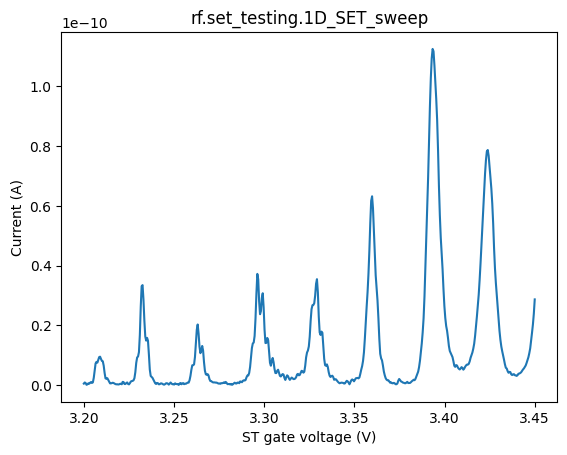

In [23]:
swiper.plotsweep1d(np.linspace(low, high, pts), result["R"], "ST", monty)

In [24]:
si.ST(3.35)